## Use sentence embedding to cluster text

### Dataset used : ag-news ( https://huggingface.co/datasets/ag_news)
### Model Used :  

In [ ]:
!pip install datasets

     |████████████████████████████████| 264 kB 8.6 MB/s 
     |████████████████████████████████| 243 kB 51.6 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 118 kB 76.2 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from datasets import load_dataset

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline

In [ ]:
print(tf.__version__)
print(hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2.5.0
0.12.0
GPU is available


In [ ]:
dataset = load_dataset("ag_news")

train_set = dataset["train"].to_pandas()
X_train_text = train_set["text"]
y_train_labels = train_set["label"]

print(train_set.head(3))

test_set = dataset["test"].to_pandas()
X_test_text = test_set["text"]
y_test_labels = test_set["label"]

print(f"X_test_text : {len(X_test_text)}")
print(f"y_test_labels : {len(y_test_labels)}")

num_classes = dataset["train"].features['label'].num_classes
class_labels = dataset["train"].features['label'].names

print(f"Number of classes : {num_classes}, Class Labels :{class_labels}")

assert dataset["train"].features['label'].num_classes == dataset["test"].features['label'].num_classes
assert dataset["train"].features['label'].names == dataset["test"].features['label'].names

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
X_test_text : 7600
y_test_labels : 7600
Number of classes : 4, Class Labels :['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
train_set.shape , test_set.shape

((120000, 2), (7600, 2))

In [ ]:
print(X_test_text[0], y_test_labels[0])

Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul. 2


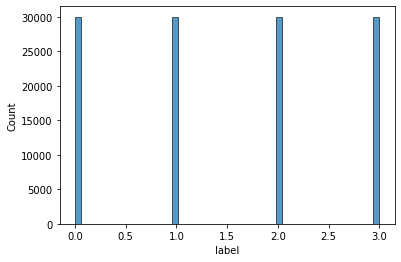

In [ ]:
sns.histplot(y_train_labels)

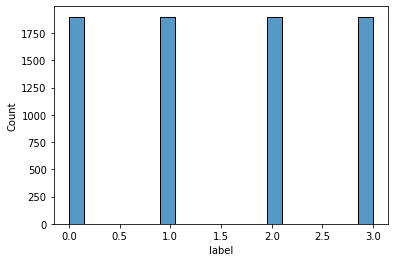

In [ ]:
sns.histplot(y_test_labels)

### Label Encoding

In [ ]:
# Convert labels to one-hot vectors
y_train = tf.keras.utils.to_categorical(y_train_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test_labels, num_classes=num_classes)
print(y_train.shape, y_test.shape)

(120000, 4) (7600, 4)


## Create Model

In [ ]:
# embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

# embedding = hub.KerasLayer(embedding_model, output_shape=512, input_shape=(), dtype=tf.string, trainable=False)
# vecs = embedding(X_train_text[:100])
# vecs.shape

In [ ]:

def create_mlp_model_with_embedding(n_classes):
    tf.keras.backend.clear_session()

    # embedding_model = "https://tfhub.dev/google/universal-sentence-encoder-large/5" # Output Shpe = (None, 512)
    # EDIM = 512
    # trainable = False
    embedding_model = "https://tfhub.dev/google/nnlm-en-dim50/2"  # Output Shpe = (None, 50)
    EDIM = 50
    trainable = True

    embedding = hub.KerasLayer(embedding_model, output_shape=EDIM, input_shape=[], dtype=tf.string, trainable=trainable)

    model = Sequential([
        embedding,
        Dropout(0.25),
        Dense(128, activation="relu"),
        Dropout(0.25),
        Dense(128, activation="relu"),
        Dropout(0.25),
        Dense(n_classes, activation="softmax")
    ])

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
    model.summary()

    return model


model = create_mlp_model_with_embedding(num_classes)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 5

In [ ]:
es = tf.keras.callbacks.EarlyStopping(min_delta=1e-5, patience=2)
hist = model.fit(X_train_text, y_train,
                 batch_size=32,
                 epochs=20,
                 verbose=1,
                 validation_data=(X_test_text, y_test),
                 callbacks=[es])


Epoch 1/20
3750/3750 [==============================] - 111s 29ms/step - loss: 0.3201 - accuracy: 0.8925 - val_loss: 0.2410 - val_accuracy: 0.9172
Epoch 2/20
3750/3750 [==============================] - 107s 29ms/step - loss: 0.1901 - accuracy: 0.9349 - val_loss: 0.2351 - val_accuracy: 0.9195
Epoch 3/20
3750/3750 [==============================] - 107s 28ms/step - loss: 0.1369 - accuracy: 0.9514 - val_loss: 0.2801 - val_accuracy: 0.9143
Epoch 4/20
3750/3750 [==============================] - 106s 28ms/step - loss: 0.1013 - accuracy: 0.9626 - val_loss: 0.3030 - val_accuracy: 0.9167


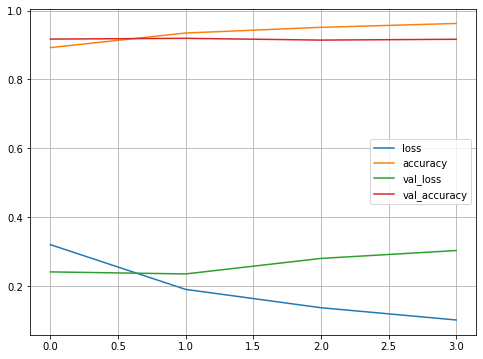

In [ ]:
hdf = pd.DataFrame(hist.history)
hdf.plot(grid=True, figsize=(8, 6))

## Explore the cases for which it's not *working*

In [ ]:
pred = model.predict(X_test_text)
pred_classes = np.argmax(pred, axis=-1)
mis_match = pred_classes != y_test_labels

i = 0
for text, pred_class, actual_class in zip(X_test_text[mis_match], pred_classes[mis_match], y_test_labels[mis_match]):
    i += 1
    print(f"{i} - Text \t: {text}")
    print(f"Predicted Class : {pred_class} {class_labels[int(pred_class)]}")
    print(f"Actuall Class \t: {actual_class} {class_labels[int(actual_class)]}")

    if i >= 10:
        break

1 - Text 	: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.
Predicted Class : 1 Sports
Actuall Class 	: 3 Sci/Tech
2 - Text 	: E-mail scam targets police chief Wiltshire Police warns about "phishing" after its fraud squad chief was targeted.
Predicted Class : 0 World
Actuall Class 	: 3 Sci/Tech
3 - Text 	: IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991.
Predicted Class : 2 Business
Actuall Class 	: 3 Sci/Tech
4 - Text 	: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum of just f

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [ ]:
class_labels = list(class_labels)
class_labels

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
print(classification_report(y_test_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1900
           1       0.96      0.98      0.97      1900
           2       0.89      0.88      0.89      1900
           3       0.89      0.89      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



In [ ]:
print(confusion_matrix(y_test_labels, pred_classes))

[[1744   38   64   54]
 [  24 1855   15    6]
 [  66   13 1669  152]
 [  56   23  122 1699]]


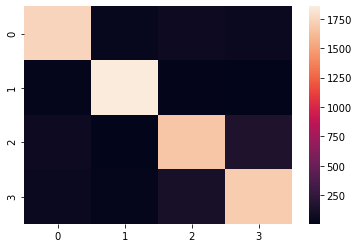

In [ ]:
sns.heatmap(confusion_matrix(y_test_labels, pred_classes))